# Welcome!
## Here you can find your own particles from the CMS data.

By clicking on the graph, you can see which particle belongs to the peak. This graph was made using CMS data. Some particles in the accelerator decay into muon particles. We can track these muons and calculate what mass the original particle had, the invariant mass. Some muons were not created from a decaying particle, which means the results are useless. Only the peaks of the graphs are interesting; those masses belong to real particles that decayed into muons. Click on the peaks to find out what particles you found!

Besides the mass and name of the particle, you can see the 'width'. This means the original particle does not always have the same weight. Because of the Heisenberg principle, particles that have a short life have a less defined energy. We can represent this using the width.

Finally, you can see the quark composition of the particles. Almost every particle in this graph is a meson, which means it exists of two quarks.

To run each code cell, click into the cell and press "Shift" and "Enter" simultaneously. 

## Tools Used
Several tools were used to create this program. You can find breif descriptions in the code comments below. Make sure to run this before you start! 

An error message will show up in the first run, but it will go away if you run this again. 

In [2]:
import pandas as pd 
#pandas is for data structures and data analysis tools
import numpy as np
#numpy is for scientific computing
import matplotlib.pyplot as plt
#matplotlib is for plotting
from ipywidgets import interact, widgets
%matplotlib inline

## The Data

These displays come from real CMS data, a particle detector at CERN in Switzerland. For this example, we used a data set with two muons, which we knew would have some interesting peaks. 

However, there are many more data sets to explore and analyze, which can be discovered at: http://opendata.cern.ch/record/545

In [3]:
dimuon = pd.read_csv('http://opendata.cern.ch/record/545/files/Dimuon_DoubleMu.csv')
dimuon.head()

,Run,Event,type1,E1,px1,py1,pz1,pt1,eta1,phi1,...,type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,165617,74601703,G,9.6987,-9.5104,0.3662,1.8633,9.5175,0.1945,3.1031,...,G,9.7633,7.3277,-1.1524,6.3473,7.4178,0.7756,-0.1560,1,17.4922
1,165617,75100943,G,6.2039,-4.2666,0.4565,-4.4793,4.2910,-0.9121,3.0350,...,G,9.6690,7.2740,-2.8211,-5.7104,7.8019,-0.6786,-0.3700,1,11.5534
2,165617,75587682,G,19.2892,-4.2121,-0.6516,18.8121,4.2622,2.1905,-2.9881,...,G,9.8244,4.3439,-0.4735,8.7985,4.3697,1.4497,-0.1086,1,9.1636
3,165617,75660978,G,7.0427,-6.3268,-0.2685,3.0802,6.3325,0.4690,-3.0992,...,G,5.5857,4.4748,0.8489,-3.2319,4.5546,-0.6605,0.1875,1,12.4774
4,165617,75947690,G,7.2751,0.1030,-5.5331,-4.7212,5.5340,-0.7736,-1.5522,...,G,7.3181,-0.3988,6.9408,2.2825,6.9523,0.3227,1.6282,1,14.3159


## Finding Information From The Data

You can see the vast amount of data that we have to analyze. What we really want to see is the invariant mass, and hopefully find peaks and match them to particles. Run this cell to see the invariant mass of all the events that were noted. 

You can see that it would be hard to identify the peaks like this, looking through the data would take a lot of time and possible peaks could be missed as a result of bias from the physicist looking at it. 

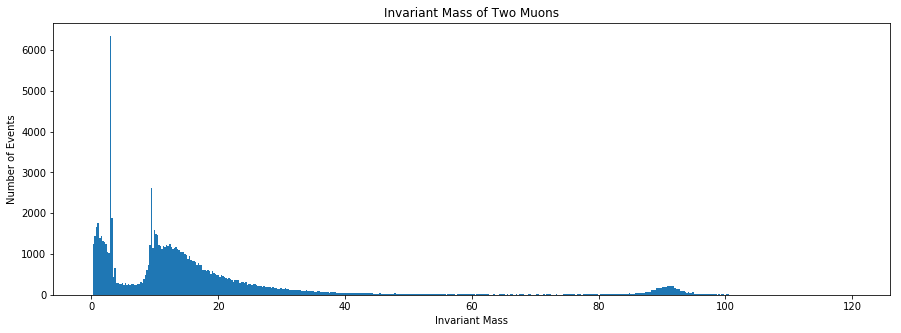

In [4]:
plt.figure(figsize = (15,5))
plt.title('Invariant Mass of Two Muons')
plt.xlabel('Invariant Mass')
plt.ylabel('Number of Events')
#set plot settings

plt.hist(dimuon.M, bins = 500, range = (0, 120))
#plot

plt.show()
#display

## Peak Detection

The idea behind our peak detection algorithm can be described as a statistical approach for finding deviations in a dataset. We first define a way to slice up our data into distinct ranges of masses, where the length of each slice increases proportionally to the energy level we are analyzing. The two filters we use to find our peaks are standard deviation and mode value and here is how we implement them in our algorithm:
    
Since we have divided our dataset into slices, we can look for slices where the standard deviation is relatively small. This would isolate areas where the count of particle detections fluctuates in close proximity to a certain number. This, of course, isn't enough to reach our goal, because that would add flat areas in the dataset to our peaks array. This is where the mode value comes into play.

If the mode of the slice we are analyzing at any given moment equals to any previous inspected energy, that means that we are isolating the same peak once again and therefore we should add it to the respective counter.

In the end, what all this means is that the found modes which have a small standard deviation to energy value ratio (we use the ratio because of the increasing slice length), but a great counter amount resemble the peaks we are looking for in our dataset.

The user could pick the values "std_max" and "min_count" (2.5% and 30 work best in this case) using the provided sliders in order to get the peaks array that suits his needs the most.


In [5]:
stdSlider = widgets.FloatSlider(
    value=2.5,
    min=2,
    max=4,
    step=0.01,
    description='std_max = ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',)

print('Pick a max standard deviation value (in %):')
display(stdSlider)

minSlider = widgets.IntSlider(
    value=30,
    min=0,
    max=50,
    step=1,
    description='min_count = ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',)

print('Pick a max count value (in %):')
display(minSlider)

Pick a max standard deviation value (in %):


FloatSlider(value=2.5, continuous_update=False, description='std_max = ', max=4.0, min=2.0, step=0.01)

Pick a max count value (in %):


IntSlider(value=30, continuous_update=False, description='min_count = ', max=50)

In [6]:
std_range = stdSlider.value/100
min_count = minSlider.value

# Each slice overlaps with up to 50 previous slices of data.
#
# It will grow the slice size a little bit as the energy gets higger
def next_slice(last_start, last_end):
    last_step = last_end - last_start
    next_start = last_start + last_step / 50
    next_end = next_start * 1.0955
    return (next_start, next_end)

# Energy limit to search
maximum = 120

# Initialize slice limits and mode list
(st, end) = next_slice(0.4, 0.4)
modes = []


while  True:
    # We got to the end of the dataset, just end the iteration
    if end > maximum:
        break

    # We get the slice of data
    slc = dimuon[(dimuon.M >= st) & (dimuon.M <= end)]

    # We calculate the mean, mode and standard deviation
    mode = slc.M.mode().mean()
    std = slc.M.std()

    # We set the "modified" variable to know if we chnged the modes
    modified = False
    for idx, item in enumerate(modes):
        if item['val'] == mode:
            # There was some other mode with this energy before, we add one to the counter
            modes[idx]['count'] += 1
            if item['std'] > std:
                # The new standard deviation is lower, let's update it
                modes[idx]['std'] = std
            modified = True
            break

    # There was no previous mode with this energy, let's add a new one
    if not modified:
        modes.append({'val': mode, 'count': 1, 'std': std})

    # Get the next slice limits
    (st, end) = next_slice(st, end)
    
peaks = (p for p in modes if (p['std']/p['val'] < std_range and p['count'] > min_count))

massPeaks = np.array([])

def appMass(num):
    temp = int(num*1000)
    return float(temp/1000)

for peak in peaks:
    massPeaks = np.append(massPeaks, appMass(peak['val']))
    
print('These are the peaks we get: \n' + str(massPeaks))

These are the peaks we get: 
[ 0.545  0.77   1.008  1.222  2.462  3.106  3.716  5.323  6.748  9.454
 19.516 56.523 91.139]


## Particle Information
To be able to tell you about a peak, the program has to have some infromation on it. Here, we load a database of particles and their properties to be able to accuratley match them to the peaks we find. Run this cell to load the data, and see it in a rought table. 

In [7]:
#read the particle listing
df = pd.read_csv('https://raw.githubusercontent.com/cms-opendata-education/scool-lab-sc18-opendata/master/ListOfParticles.csv')
#and for practical reasons set the particle name as index
df2 = df.set_index("Particle", drop = False)
print(df2)

          Unnamed: 0  Mass (GeV)  Particle  Width (MeV) Quark composition
Particle                                                                 
η                  0       0.548         η      0.00131       complicated
ω (782)            1       0.783   ω (782)      8.49000       complicated
ρ (770)            2       0.775   ρ (770)    150.00000       complicated
K°                 3       0.498        K°          NaN               ds̄
D⁰                 4       1.860        D⁰          NaN               cū
ϕ (1020)           5       1.020  ϕ (1020)      4.27000               ss̄
B⁰                 6       5.280        B⁰          NaN               db̄
B⁰                 7       5.370        B⁰          NaN               sb̄
J/ψ (1S)           8       3.100  J/ψ (1S)      0.09290               cc̄
ψ (2S)             9       3.690    ψ (2S)      0.29600               cc̄
ψ (4160)          10       4.190  ψ (4160)     70.00000               cc̄
η (1S)            11       9.400    η 

## Peak Selection - Cleaning Up the Data
Unfortunatly the algorithm is unable to perfectly filter out all the peaks.For now, this must be supplemented with human intelligence. The following block of code separates the peaks into ones that are capable of being matched to particles, and others than are not. It then moves through the unmatched peaks and asks the user whether this "peak" is valid, or should be removed. The matched and selected peaks move on to the final display.

[0.545, 0.77, 3.106, 3.716, 9.454, 91.139]
[1.008, 1.222, 2.462, 5.323, 6.748, 19.516, 56.523]


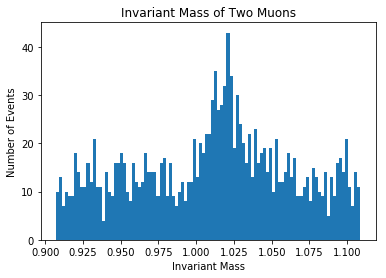

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 1.008.
Shall I remove it from the list? (y/n)    n


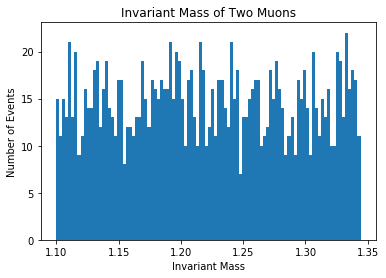

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 1.222.
Shall I remove it from the list? (y/n)    y


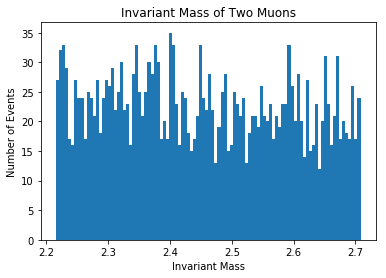

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 2.462.
Shall I remove it from the list? (y/n)    y


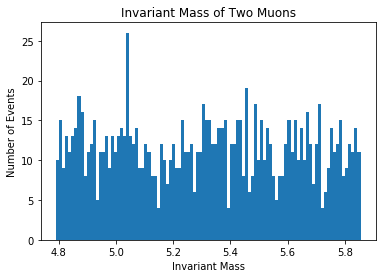

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 5.323.
Shall I remove it from the list? (y/n)    y


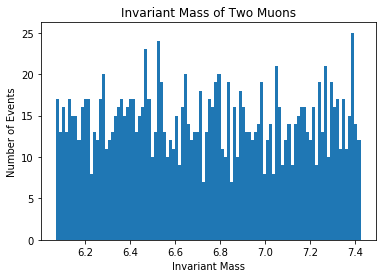

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 6.748.
Shall I remove it from the list? (y/n)    y


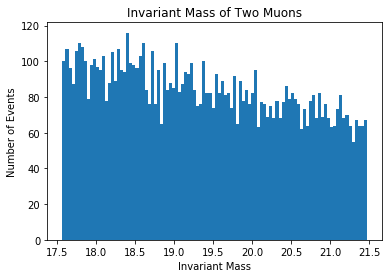

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 19.516.
Shall I remove it from the list? (y/n)    y


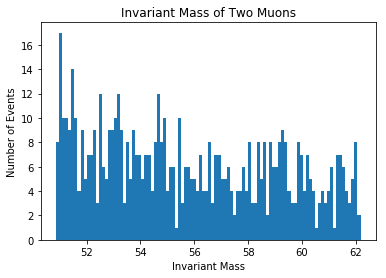

Sorry! I cannot find a particle match for this peak. Here is a display of it.
It has a mass of 56.523.
Shall I remove it from the list? (y/n)    y

Here are the peaks that we will be using: 
[0.545, 0.77, 1.008, 3.106, 3.716, 9.454, 91.139]


In [8]:
matched = []
unmatched = []

for mypeak in massPeaks:
    myerror = .01*mypeak
    myparticle = df2.loc[(df2['Mass (GeV)']  < mypeak + myerror) & (df2['Mass (GeV)']  > mypeak - myerror) ]
    try:
        x = myparticle['Particle'][0]
        matched.append(mypeak)
    except:
        unmatched.append(mypeak)
    
print(matched)
print(unmatched)

for fpeak in unmatched:
    frange = 0.1*fpeak
    plt.hist(dimuon.M, bins=100, range=(fpeak-frange,fpeak+frange))
    plt.title('Invariant Mass of Two Muons')
    plt.xlabel('Invariant Mass')
    plt.ylabel('Number of Events')
    plt.show()
    print('Sorry! I cannot find a particle match for this peak. Here is a display of it.')
    print('It has a mass of ' + str(fpeak) + '.')
    ans = str(input('Shall I remove it from the list? (y/n)    '))
    if ans == 'n':
        matched.append(fpeak)

matched.sort()
names = {}
for i in range(len(matched)):
    names[(str(matched[i]) + ' GeV')]= i
        

print('\nHere are the peaks that we will be using: \n' + str(matched))

## Final Particle Display
Finally, we are ready to display the peaks and the particles they represent. Run the code below to learn about the particles!

Select which peak you want to look at using the dropdown menu at the top. 


In [10]:
def f(n):
    mypeak = matched[n]
    myerror = .05*mypeak
    myparticle = df2.loc[(df2['Mass (GeV)']  < mypeak + myerror) & (df2['Mass (GeV)']  > mypeak - myerror) ]
    try:
        print('This particle could be', myparticle['Particle'][0], 'with mass of', round(df2.loc[myparticle['Particle'][0],'Mass (GeV)'],3), 'GeV/c2')
        if myparticle['Quark composition'][0] != '-'  and myparticle['Quark composition'][0] != 'complicated':
            print('The quark composition of this particle is', myparticle['Quark composition'][0] + '.')
        if myparticle['Width (MeV)'][0] == myparticle['Width (MeV)'][0]:
            print('The natural width of this particle is', round(myparticle['Width (MeV)'][0],3), 'MeV')

    except:
        print('Sorry! I cannot match a particle here.')
    myrange = .1*mypeak
    plt.hist(dimuon.M, bins=100, range=(mypeak-myrange,mypeak+myrange))
    plt.title('Invariant Mass of Two Muons')
    plt.xlabel('Invariant Mass')
    plt.ylabel('Number of Events')
    plt.show()
    
interact(f, n=(names))

interactive(children=(Dropdown(description='n', options={'0.545 GeV': 0, '0.77 GeV': 1, '1.008 GeV': 2, '3.106 GeV': 3, '3.716 GeV': 4, '9.454 GeV': 5, '91.139 GeV': 6}, value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.f(n)>